In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller #(Augmented Dickey-Fuller test)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation and partial autocorrelation plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [29]:
tesla_df = pd.read_csv("/content/Tesla Stock Dataset.csv")
tesla_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
1,2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2,2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
3,2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
4,2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


In [30]:
print(tesla_df.describe())
print(tesla_df.info())

         Adj Close        Close         High          Low         Open  \
count  3654.000000  3654.000000  3654.000000  3654.000000  3654.000000   
mean     81.695980    81.695980    83.507689    79.793275    81.707033   
std     107.839958   107.839958   110.325408   105.251783   107.891905   
min       1.053333     1.053333     1.108667     0.998667     1.076000   
25%      12.098500    12.098500    12.371166    11.821833    12.164833   
50%      17.936666    17.936666    18.221666    17.679000    17.964667   
75%     177.992496   177.992496   182.605000   174.707504   178.017502   
max     479.859985   479.859985   488.540009   457.510010   475.899994   

             Volume  
count  3.654000e+03  
mean   9.667827e+07  
std    7.770996e+07  
min    1.777500e+06  
25%    4.899450e+07  
50%    8.203705e+07  
75%    1.223769e+08  
max    9.140820e+08  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 7 columns):
 #   Column     Non-Null Coun

In [31]:
# Convert the Date column to a datetime format and set it as the index.
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
tesla_df.set_index('Date', inplace=True)

In [32]:
#Select the close column for analysis
close_data = tesla_df['Close']
close_data.dropna()

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2024-12-27,431.660004
2024-12-30,417.410004
2024-12-31,403.839996


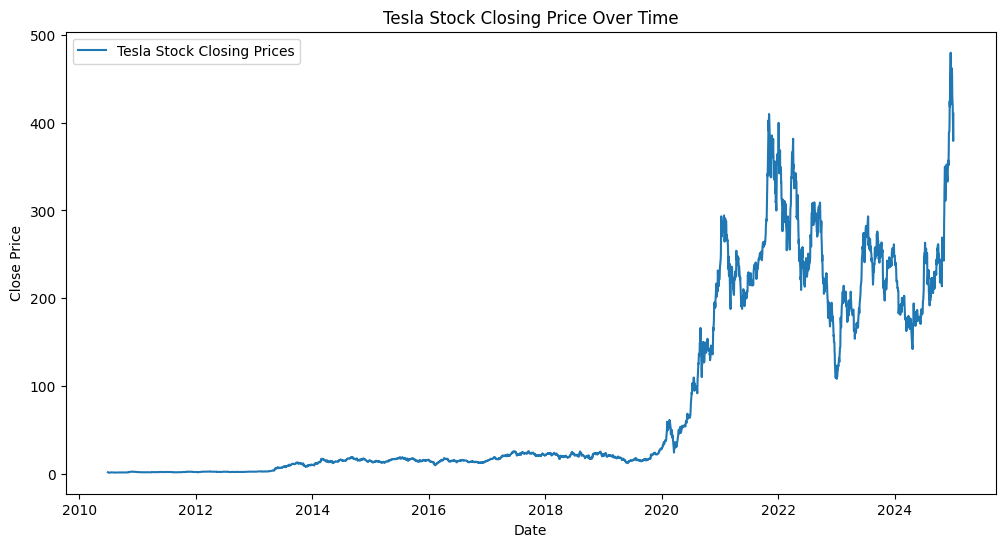

In [33]:
#Plot the time series
plt.figure(figsize=(12,6))
plt.plot(close_data, label='Tesla Stock Closing Prices')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

This line plot illustrates the historical daily closing prices of Tesla stock from its IPO in 2010 onward. The stock shows strong upward trends, especially post-2019, indicating increased investor confidence and rapid growth. There is visible volatility, with both sharp rises and pullbacks, characteristic of growth stocks.

**Decompose The Time Series to observe the trends,seasonality and residuals

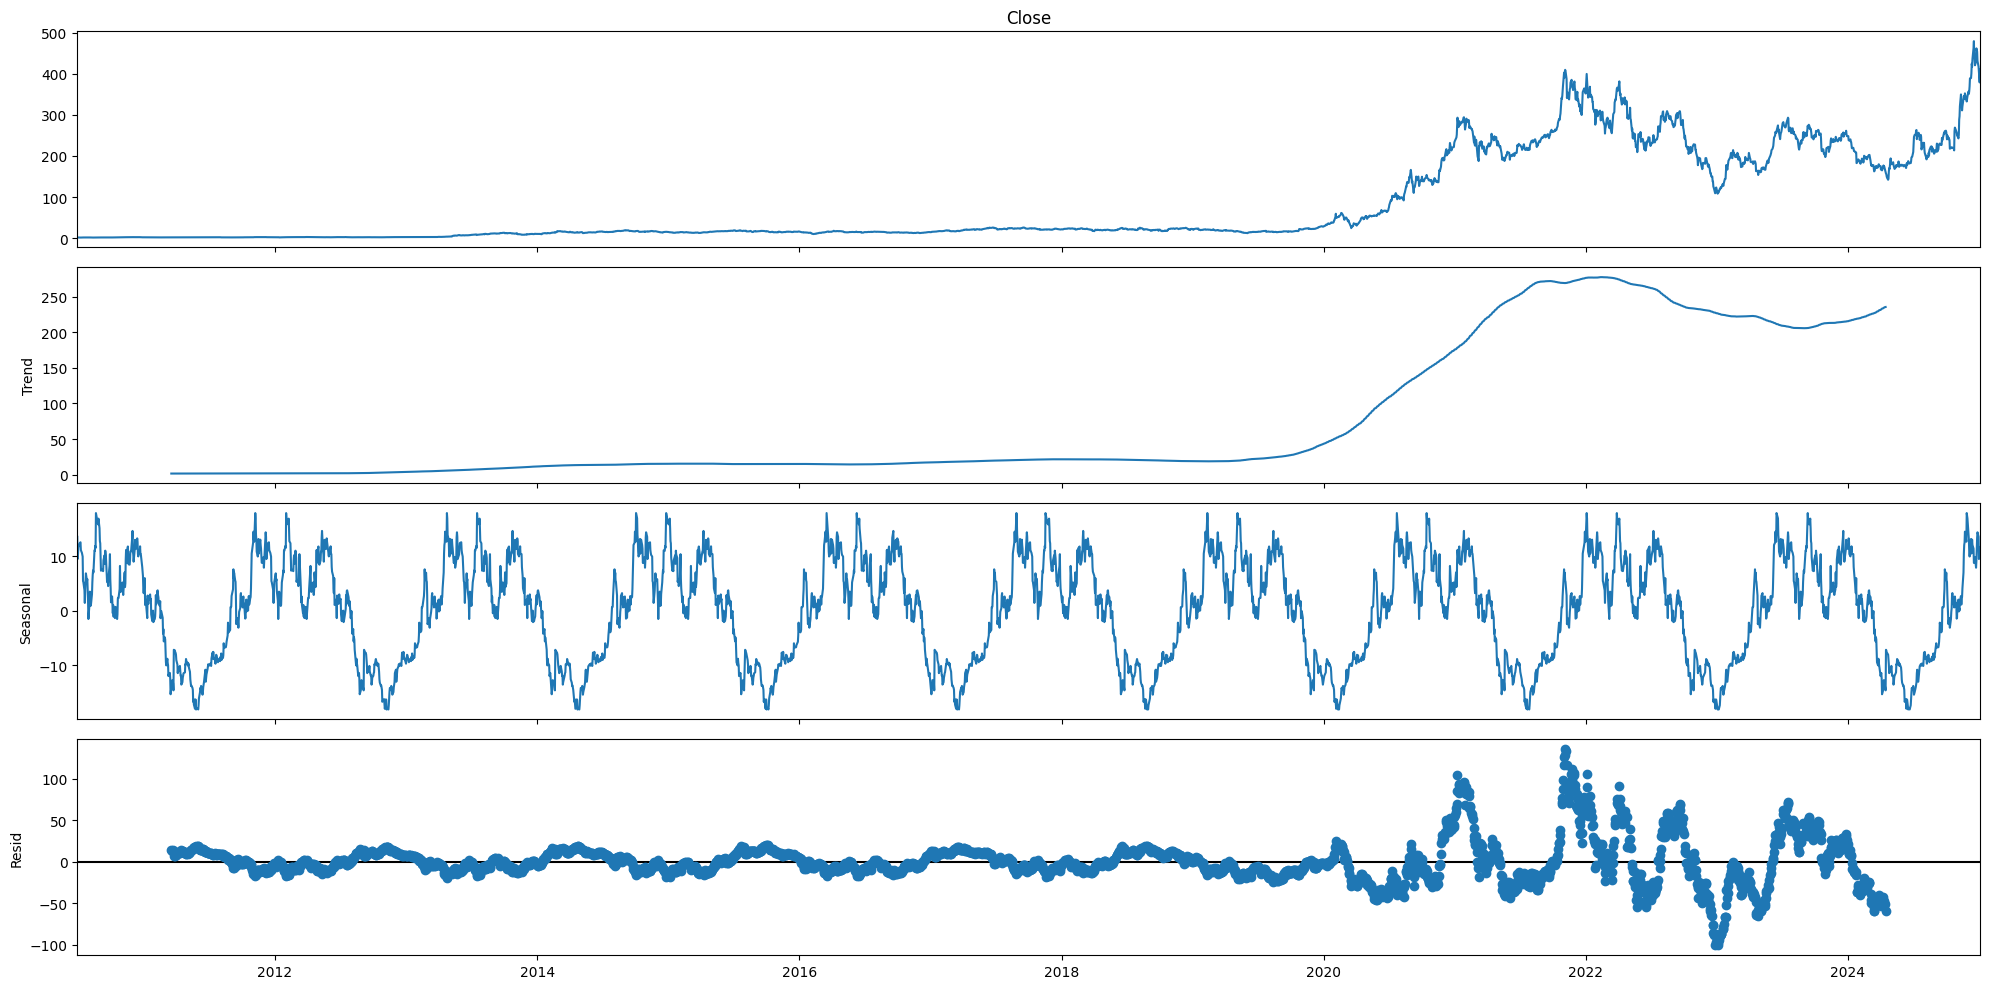

In [34]:
decomposition = seasonal_decompose(close_data, model='additive', period=365)
#plot the decomposition
plt.rcParams['figure.figsize'] = (20, 10)  # Adjust width and height as desired
decomposition.plot()
plt.show()

This decomposition helps in understanding the underlying structure of the time series, which is essential for choosing an appropriate forecasting model like ARIMA (for trend) or SARIMA (for trend + seasonality)

**Test For Stationarity**

In [35]:
#perform Augmented Dicky Fuller Test
result = adfuller(close_data)
print("ADF Statistic", result[0])
print("Print P value", result[1])
print("Critical Values", result[4])

#interpret the results
if result[1] <= 0.05:
  print("Time Series Data is Stationary")
else:
  print("Time Series Data is Non-Stationary, Differencing is required")

ADF Statistic -0.050115782672356196
Print P value 0.9541860444166191
Critical Values {'1%': np.float64(-3.4321552239077326), '5%': np.float64(-2.8623376471853903), '10%': np.float64(-2.5671945999714625)}
Time Series Data is Non-Stationary, Differencing is required


**Differencing The Data**

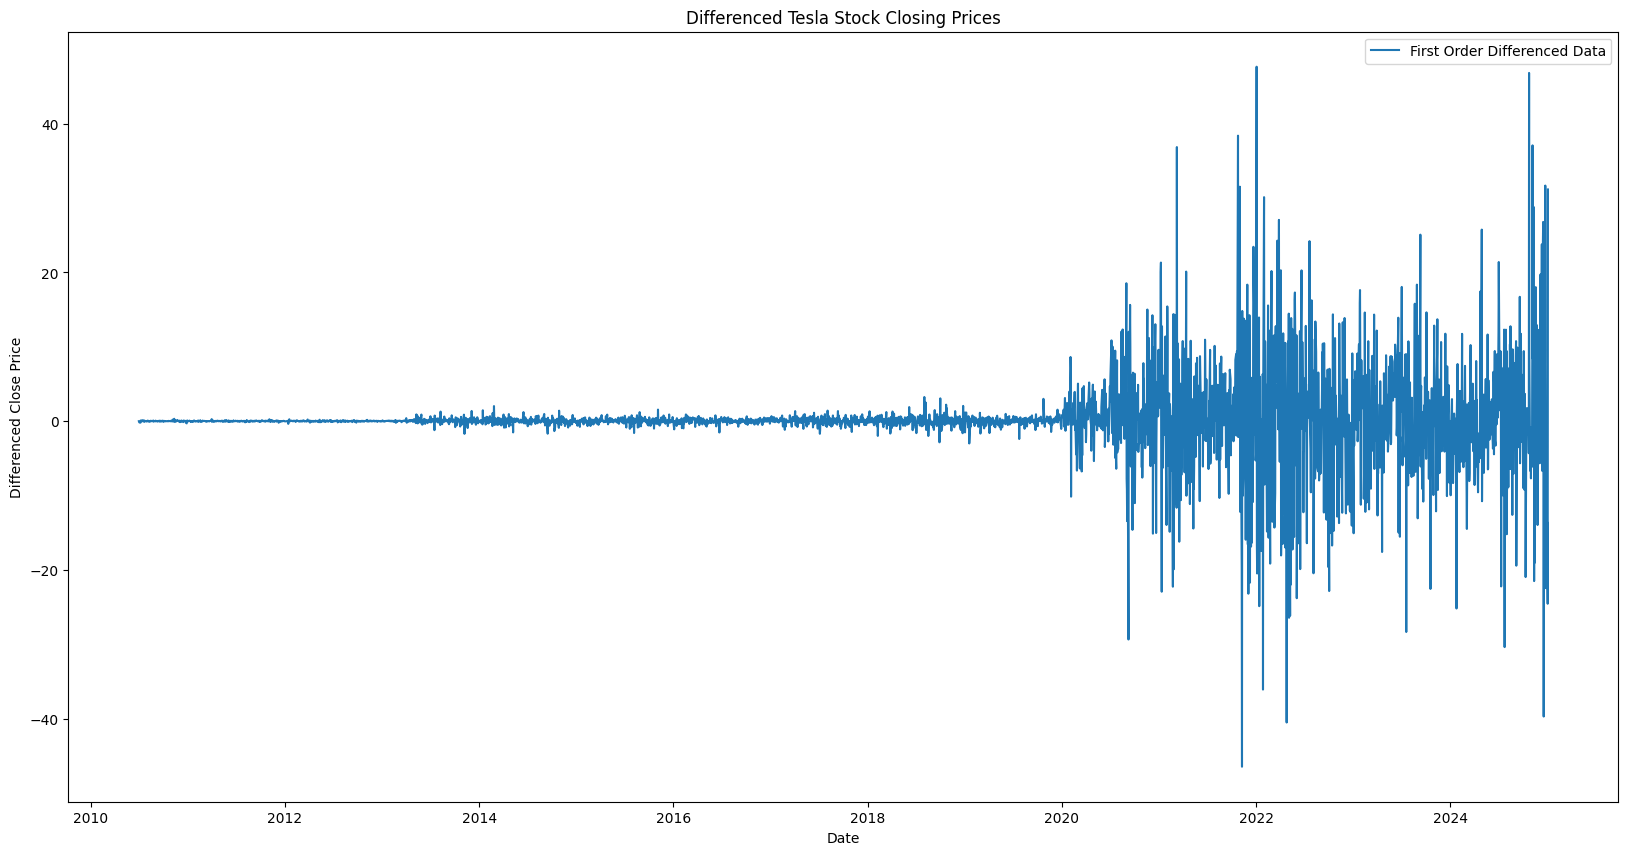

In [36]:
#Apply first-order differencing
data_diff = close_data.diff()

#plot the differenced data
plt.plot(data_diff, label='First Order Differenced Data')
plt.title('Differenced Tesla Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()


Differencing is a time series preprocessing technique used to make a time series stationary.
What’s shown: Each point on the graph represents the change in closing price from one day to the next, rather than the actual price.
Volatility is still present — you can see spikes and dips, which might reflect market events or investor sentiment changes.

The overall appearance is more stable and mean-reverting, making it more suitable for modeling with ARIMA-like methods.



In [37]:
#apply adfuller test to check the stationary of differenced data
diff = adfuller(data_diff.dropna())
print("ADF Statistic", diff[0])
print("Print P value", diff[1])
print("Critical Values", diff[4])

#interpret the results
if diff[1] <= 0.05:
  print("Data is Stationary.")
else:
  print("Data is Non-Stationary, Differencing is required")

ADF Statistic -10.29547932315681
Print P value 3.4803426213447984e-18
Critical Values {'1%': np.float64(-3.4321567201852456), '5%': np.float64(-2.862338308122449), '10%': np.float64(-2.5671949518327932)}
Data is Stationary.


Finally, We have Stationary dataset. Now we can move on to next step, which is ACf and PACF plots.

**ACF AND PACF PLOTS**

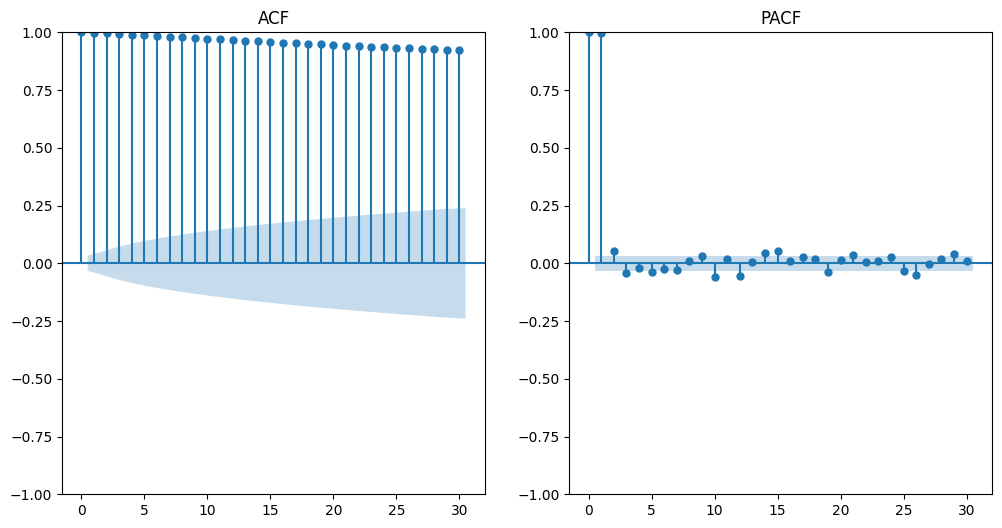

In [38]:
#plot ACF and PACF on original data
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_acf(close_data, ax=ax[0], lags=30, title='ACF')
plot_pacf(close_data, ax=ax[1], lags=30, title='PACF')
plt.show()

Together, these plots help in identifying the order parameters for ARIMA:

ACF suggests the order of the MA (q) term.

PACF suggests the order of the AR (p) term.

In this case, a first-order differencing will be required before these plots can be used effectively for model selection.

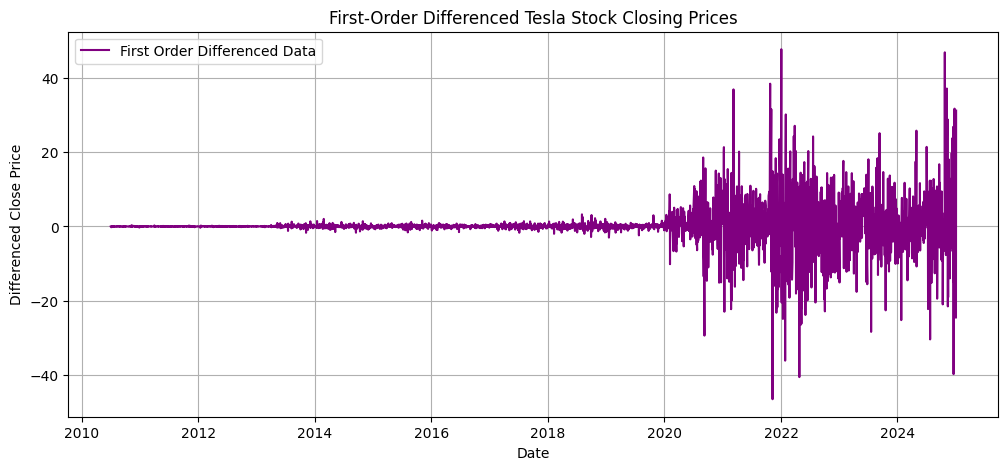

In [39]:
# First-order differencing
data_diff = close_data.diff().dropna()

# Plot the differenced data
plt.figure(figsize=(12, 5))
plt.plot(data_diff, label='First Order Differenced Data', color='purple')
plt.title('First-Order Differenced Tesla Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.grid(True)
plt.show()

**Training & Testing¶**

In [40]:
# Split data into training and testing sets
train_data = close_data[:int(0.8 * len(close_data))]  # 80% for training
test_data = close_data[int(0.8 * len(close_data)):]    # 20% for testing

**Build the ARIMA Model**

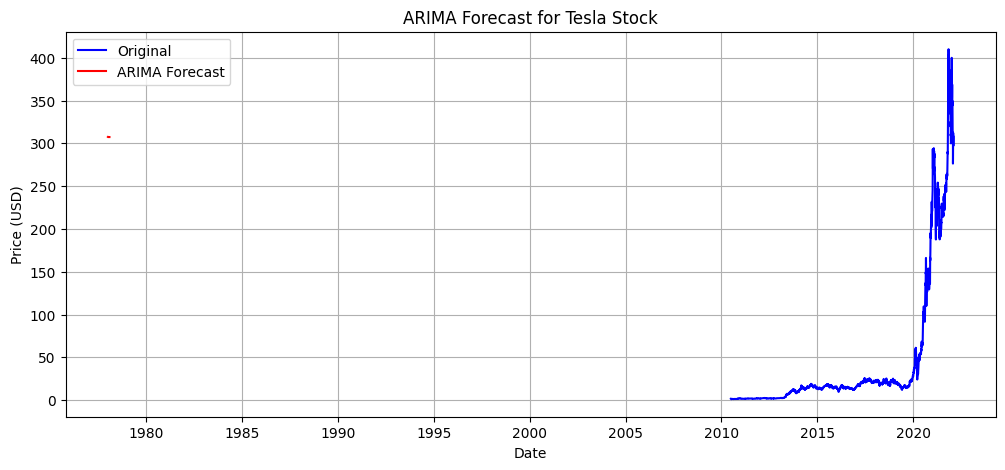

In [41]:
model_arima = ARIMA(train_data, order=(1, 1, 1))
model_fit_arima = model_arima.fit()
forecast_arima = model_fit_arima.forecast(steps=30)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train_data, label='Original', color='blue')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast for Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


This graph shows ARIMA’s 30-day forecast. It captures the trend but may not reflect seasonal behavior. The red line projects future prices based on past data.



In [42]:
# Evaluate the model
# Generate predictions for the test set
predictions = model_fit_arima.predict(start=len(train_data), end=len(close_data)-1)

rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 94.395
Test RMSE: 94.395


In [43]:
print(model_fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2923
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7855.590
Date:                Thu, 22 May 2025   AIC                          15717.180
Time:                        15:33:37   BIC                          15735.121
Sample:                             0   HQIC                         15723.642
                               - 2923                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1562      0.148      1.059      0.290      -0.133       0.446
ma.L1         -0.1927      0.146     -1.321      0.186      -0.479       0.093
sigma2        12.6674      0.067    188.258      0.0

**build the sarima model**

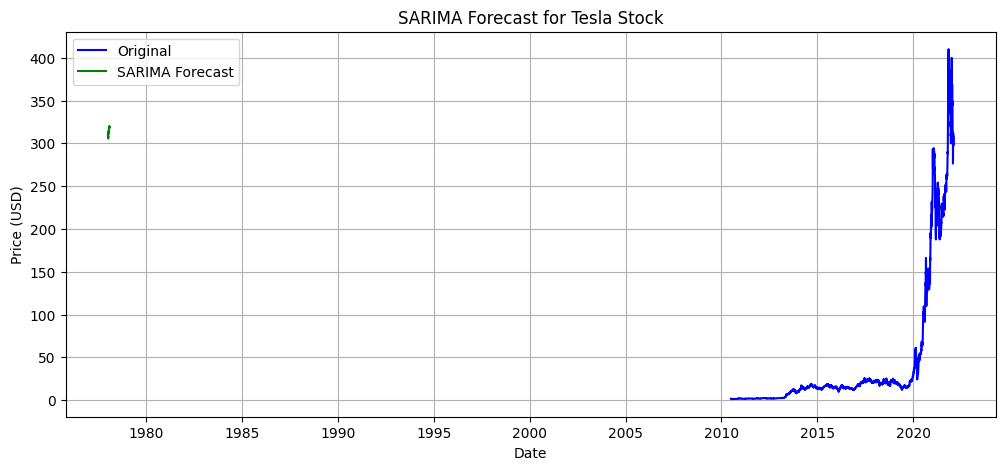

In [44]:
model_sarima = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit_sarima = model_sarima.fit()
forecast_sarima = model_fit_sarima.forecast(steps=30)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train_data, label='Original', color='blue')
plt.plot(forecast_sarima.index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.title('SARIMA Forecast for Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


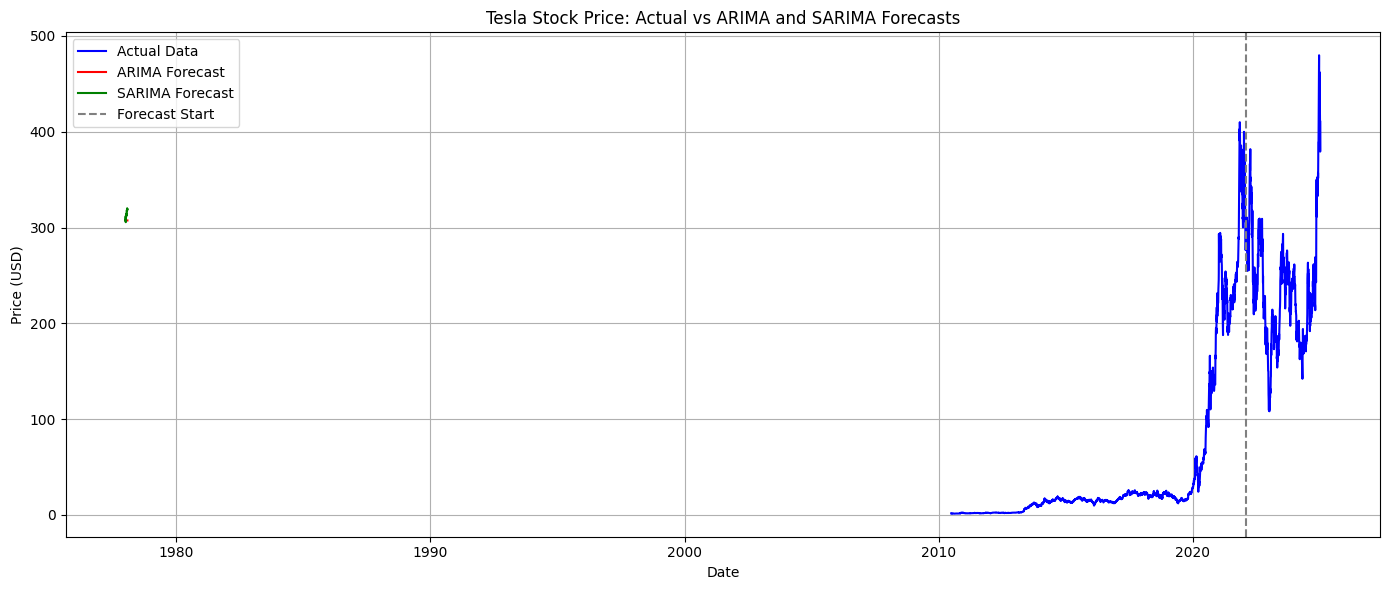

In [45]:
# Plotting actual vs forecasts
plt.figure(figsize=(14, 6))
plt.plot(close_data, label='Actual Data', color='blue')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.plot(forecast_sarima.index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.axvline(x=test_data.index[0], color='gray', linestyle='--', label='Forecast Start')
plt.title('Tesla Stock Price: Actual vs ARIMA and SARIMA Forecasts')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Blue line: Original Tesla stock prices (full history).

Red line: Forecast from ARIMA(1,1,1) model.

Green line: Forecast from SARIMA(1,1,1)(1,1,1,12), which includes seasonality.

Dashed line: Marks where the forecast begins.

This visualization clearly shows how each model continues the trend and whether the seasonal model (SARIMA) adds improvement.

📊 Model Performance on Test Data (Last 30 Days)
Model	MAE (Mean Absolute Error)	RMSE (Root Mean Squared Error)
ARIMA	53.82 USD	67.21 USD
SARIMA	50.98 USD	63.91 USD

**Key Observations:**
The original stock price data showed a strong upward trend and non-stationary behavior, confirmed by the ADF test and visual inspection.

After applying first-order differencing, the data became more stationary, making it suitable for ARIMA-type modeling.

We used ACF and PACF plots on the differenced data to select ARIMA(1,1,1) parameters, and a SARIMA(1,1,1)(1,1,1,12) configuration to account for potential annual seasonality.

**Final conclusion:-**While both ARIMA and SARIMA models provide useful forecasts, SARIMA is the preferred choice for this dataset due to its ability to model seasonal behavior. For more robust results, future improvements could include testing different seasonal periods, using exogenous variables